In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install tensorflow

In [2]:
import tensorflow as tf
import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from scipy.ndimage import zoom
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from PIL import Image
from skimage.transform import resize, rotate
import random
import IPython

# Load LIDC dataset
### Step 1: Load all nodules as a 3D representation in numpy array & the labels from the nodule name

In [3]:
# Select an even number of slices to extract:
num_slices = 6
# Select nodules dataset location
lidc_path = Path('F:\\master\\manifest-1600709154662\\nodules_16slices')

In [4]:
images = []
diagnostics = []
nodules_path = list(lidc_path.iterdir())
for nodule_path in nodules_path:
    images_path = list(nodule_path.iterdir())
    # Reduce the slices to the specified amount:
    images_path = images_path[int(len(images_path)/2)-int(num_slices/2):int(len(images_path)/2)+int(num_slices/2)]
    # Merge all slices of a nodule together --> create 3D representation of the nodule
    image_nodule = []
    for image_path in images_path:
        # Load slice image
        image_slice = np.array(Image.open(image_path)) / 255.0
        # Add it to the nodule
        image_nodule.append(image_slice)
    # convert the 3D nodule to numpy array
    image_nodule = np.array(image_nodule)
    
    diag = int(nodule_path.name.split('_')[5])
    # remove incorrect image shape or diagnostic incogruent
    if image_nodule.shape == (num_slices, 64, 64) and diag != 3:
        # Add the nodule 3D representation to the list of images
        images.append(image_nodule)
        # Save nodule label (diagnostic)
        diagnostics.append(diag)
    elif image_nodule.shape != (num_slices, 64, 64):
        print(f'[ERROR] {nodule_path.name} has shape {image_nodule.shape}, but expected shape is: (16, 64, 64)')
# convert the dataset to numpy array
images = np.array(images)

[ERROR] patient_462_nod_1_diag_2 has shape (6, 64, 54), but expected shape is: (16, 64, 64)
[ERROR] patient_463_nod_1_diag_2 has shape (6, 64, 54), but expected shape is: (16, 64, 64)
[ERROR] patient_655_nod_3_diag_2 has shape (6, 64, 57), but expected shape is: (16, 64, 64)
[ERROR] patient_997_nod_2_diag_1 has shape (6, 64, 55), but expected shape is: (16, 64, 64)


#### Visualize data

In [5]:
from collections import Counter
import pandas

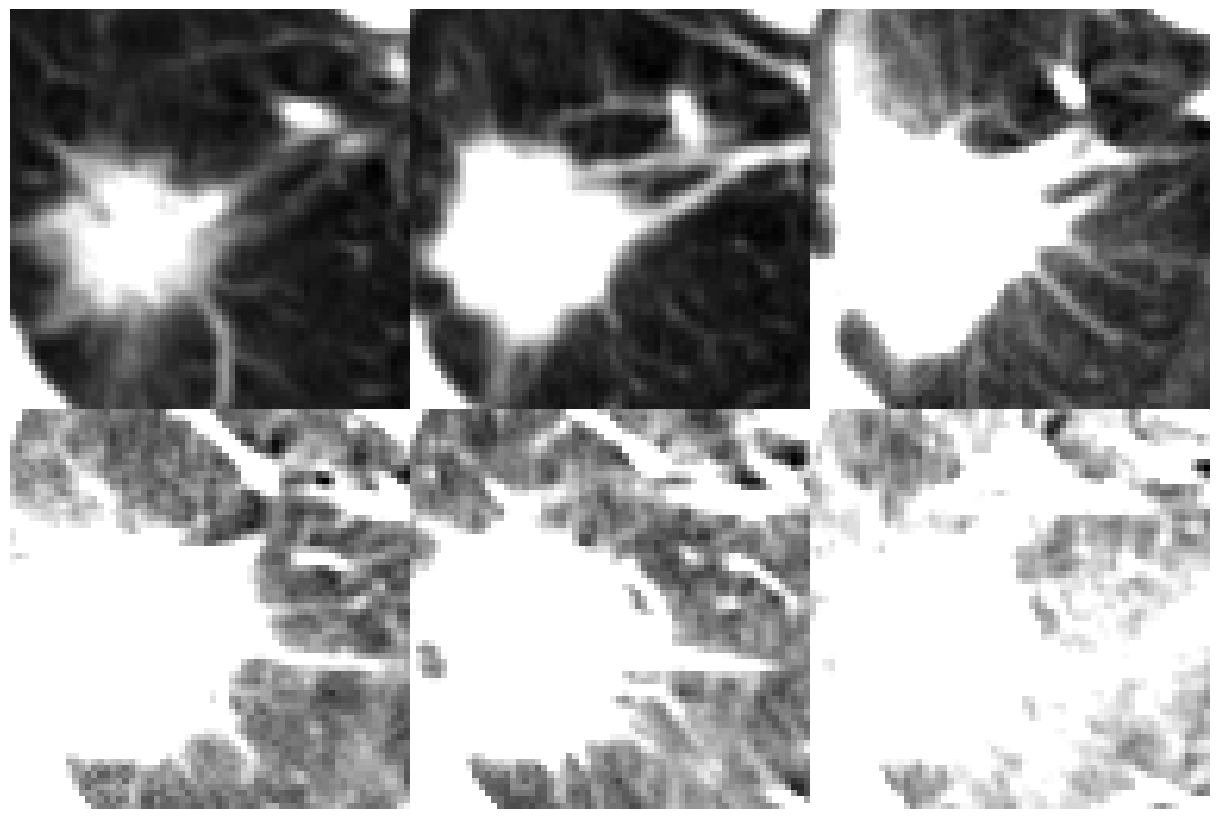

In [6]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of X CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i, j], cmap="gray")  # Corrected indexing
            #axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
plot_slices(
    num_rows=2, 
    num_columns=3, 
    width=64, 
    height=64, 
    data=images[0].transpose()
)

### Ste 2: Simplify labels
The label is a subjective assessment of the likelihood of malignancy of the given nodule, assuming the scan originated from a 60-year-old male smoker.

The original label system has 5 labels:

1: ‘Highly Unlikely’

2: ‘Moderately Unlikely’

3: ‘Indeterminate’

4: ‘Moderately Suspicious’

5: ‘Highly Suspicious’

It has been simplified to a binary clasification system, being:

0: if original label < 3 (benign)

1: if original label > 3 (malign)

In [7]:
# Simplify label system
labels = [0 if label<3 else 1 for label in diagnostics]
labels = np.array(labels)

<Axes: >

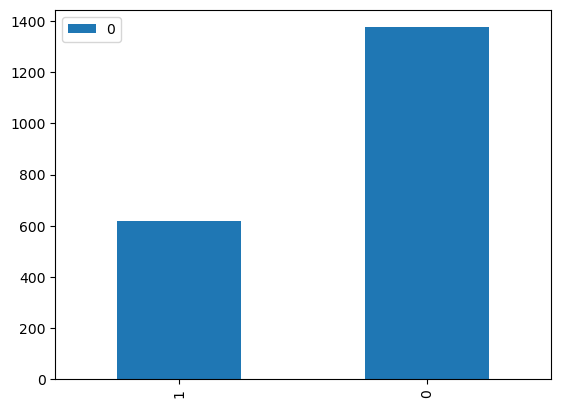

In [8]:
count = Counter(labels)
df = pandas.DataFrame.from_dict(count, orient='index')
df.plot(kind='bar')

# Data augmentation

Define function to rotate images

In [9]:
def rotate_image(image):
    # define some rotation angles
    angles = [-20, -10, -5, 5, 10, 20]
    # pick angles at random
    angle = random.choice(angles)
    # rotate volume
    image = rotate(image.transpose(), angle).transpose()
    return image

Generate new images

In [10]:
images_aug = list(images)
labels_aug = list(labels)
for i, l in zip(images, labels):
    if l==1:
        for rep in range(3):
            images_aug.append(rotate_image(i))
            labels_aug.append(l)
    elif l==0:
        if 0.8 > random.random():
            images_aug.append(rotate_image(i))
            labels_aug.append(l)  

images_aug = np.array(images_aug)
labels_aug = np.array(labels_aug)

<Axes: >

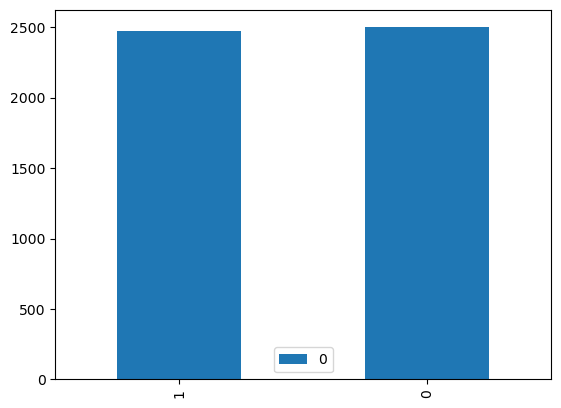

In [11]:
count = Counter(labels_aug)
df = pandas.DataFrame.from_dict(count, orient='index')
df.plot(kind='bar')

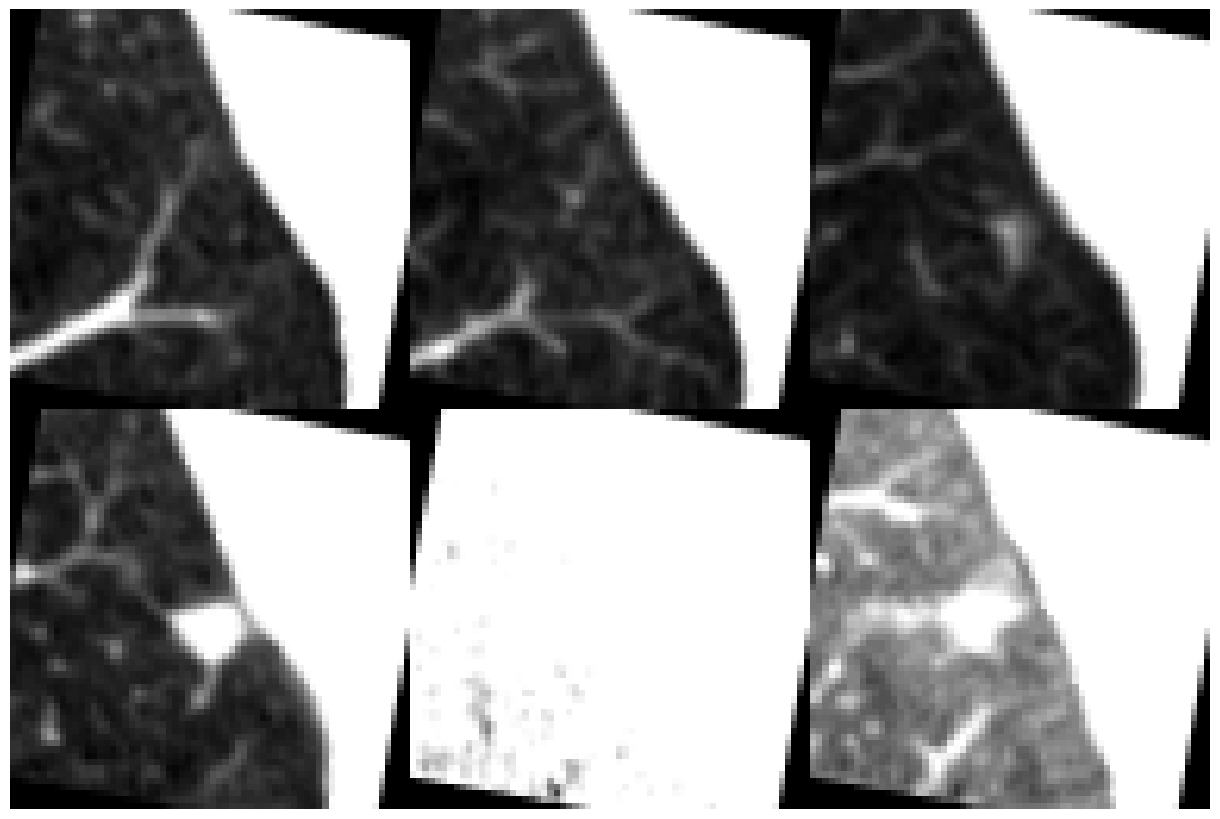

In [12]:
# Visualize montage of slices.
plot_slices(
    num_rows=2, 
    num_columns=3, 
    width=64, 
    height=64, 
    data=images_aug[-1].transpose()
)

Divide between train and test data

In [13]:
# Create train and test dataset
train_images, test_images, train_labels, test_labels = train_test_split(images_aug, labels_aug, test_size=0.33, random_state=42)

# Building the CNN:
Models used by others: https://github.com/marichka-dobko/Lung_Nodule_Classification/blob/master/src_keras/models_keras.py

In [14]:
def le_net_3d():
    model = keras.Sequential()
    model.add(layers.Convolution3D(6, kernel_size=(2, 5, 5), activation='relu', padding='same', input_shape=(6,64,64,1)))
    model.add(layers.MaxPooling3D(strides=2)) 
    model.add(layers.Convolution3D(16, kernel_size=(2, 5, 5), activation='relu', padding='same'))
    model.add(layers.MaxPooling3D(strides=2)) 

    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dense(84, activation='relu'))
    model.add(layers.Dense(2, activation='softmax'))

    return model


# Build model.
model = le_net_3d()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 6, 64, 64, 6)      306       
                                                                 
 max_pooling3d (MaxPooling3  (None, 3, 32, 32, 6)      0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 3, 32, 32, 16)     4816      
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 1, 16, 16, 16)     0         
 g3D)                                                            
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 120)               


Epoch 1/30



C:\Users\pau_a\anaconda3\Lib\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(



105/105 [==============================] - 12s 97ms/step - loss: 0.6095 - accuracy: 0.6715 - val_loss: 0.6326 - val_accuracy: 0.7034
Epoch 2/30
105/105 [==============================] - 11s 103ms/step - loss: 0.4990 - accuracy: 0.7591 - val_loss: 0.4705 - val_accuracy: 0.7795
Epoch 3/30
105/105 [==============================] - 11s 108ms/step - loss: 0.4349 - accuracy: 0.8059 - val_loss: 0.4777 - val_accuracy: 0.7747
Epoch 4/30
105/105 [==============================] - 11s 106ms/step - loss: 0.3806 - accuracy: 0.8293 - val_loss: 0.4355 - val_accuracy: 0.7966
Epoch 5/30
105/105 [==============================] - 11s 108ms/step - loss: 0.3569 - accuracy: 0.8410 - val_loss: 0.4386 - val_accuracy: 0.7978
Epoch 6/30
105/105 [==============================] - 11s 104ms/step - loss: 0.2750 - accuracy: 0.8827 - val_loss: 0.4699 - val_accuracy: 0.7911
Epoch 7/30
105/105 [==============================] - 10s 99ms/step - loss: 0.2046 - accuracy: 0.9106 - val_loss: 0.4586 - val_accuracy: 0.82

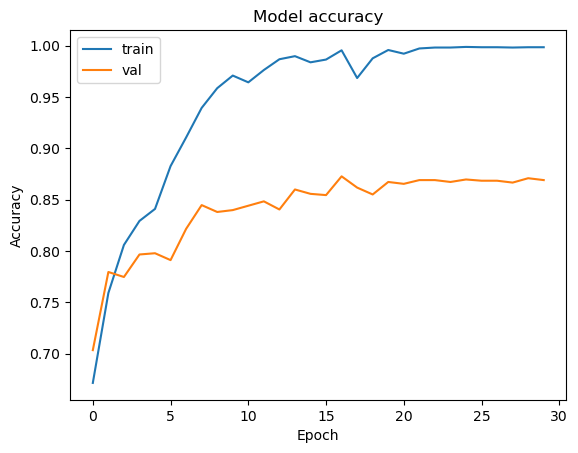

Training accuracy: 0.998499870300293
Validation accuracy: 0.8690621256828308


In [15]:
def fit_model(model, epochs):  
    model.compile(  
        optimizer="adam",  
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  
        metrics=["accuracy"],  
    )  

    history = model.fit(  
        train_images,  
        train_labels,  
        epochs=epochs,  
        validation_data=(test_images, test_labels),  
    )
    
    # Plot training history
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # Plot final model accuracy
    print(f'Training accuracy: {history.history["accuracy"][-1]}')
    print(f'Validation accuracy: {history.history["val_accuracy"][-1]}')
    return model 


model = fit_model(model, epochs=30)

# Adding Dropout

Let’s see what a slightly different model would predict on these images. We’ll now use MC dropout as our model. By sampling, we should be able to increase the models’ uncertainty compared to a standard NN. 

Let’s first define our model:

In [16]:
def le_net_3d_dropout():
    model = keras.Sequential()
    model.add(layers.Convolution3D(6, kernel_size=(2, 5, 5), activation='relu', padding='same', input_shape=(6,64,64,1)))
    
    model.add(layers.Dropout(0.2))
    model.add(layers.MaxPooling3D(strides=2)) 
    model.add(layers.Convolution3D(16, kernel_size=(2, 5, 5), activation='relu', padding='same'))
    model.add(layers.MaxPooling3D(strides=2))
    
    model.add(layers.Dropout(0.5))
    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    
    #model.add(layers.Dropout(0.5))
    model.add(layers.Dense(84, activation='relu'))
    
    #model.add(layers.Dropout(0.5))
    model.add(layers.Dense(2, activation='softmax'))

    return model

Then let’s instantiate it:

In [17]:
dropout_model = le_net_3d_dropout()
dropout_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 6, 64, 64, 6)      306       
                                                                 
 dropout (Dropout)           (None, 6, 64, 64, 6)      0         
                                                                 
 max_pooling3d_2 (MaxPoolin  (None, 3, 32, 32, 6)      0         
 g3D)                                                            
                                                                 
 conv3d_3 (Conv3D)           (None, 3, 32, 32, 16)     4816      
                                                                 
 max_pooling3d_3 (MaxPoolin  (None, 1, 16, 16, 16)     0         
 g3D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 1, 16, 16, 16)    

Epoch 1/30
105/105 [==============================] - 20s 169ms/step - loss: 0.6121 - accuracy: 0.6733 - val_loss: 0.5395 - val_accuracy: 0.7442
Epoch 2/30
105/105 [==============================] - 17s 164ms/step - loss: 0.5237 - accuracy: 0.7438 - val_loss: 0.5505 - val_accuracy: 0.7333
Epoch 3/30
105/105 [==============================] - 17s 165ms/step - loss: 0.4809 - accuracy: 0.7723 - val_loss: 0.4617 - val_accuracy: 0.7893
Epoch 4/30
105/105 [==============================] - 17s 164ms/step - loss: 0.4515 - accuracy: 0.7867 - val_loss: 0.4673 - val_accuracy: 0.7747
Epoch 5/30
105/105 [==============================] - 17s 164ms/step - loss: 0.4075 - accuracy: 0.8176 - val_loss: 0.4358 - val_accuracy: 0.8051
Epoch 6/30
105/105 [==============================] - 17s 165ms/step - loss: 0.3669 - accuracy: 0.8323 - val_loss: 0.4039 - val_accuracy: 0.8173
Epoch 7/30
105/105 [==============================] - 17s 164ms/step - loss: 0.3487 - accuracy: 0.8416 - val_loss: 0.4156 - val_ac

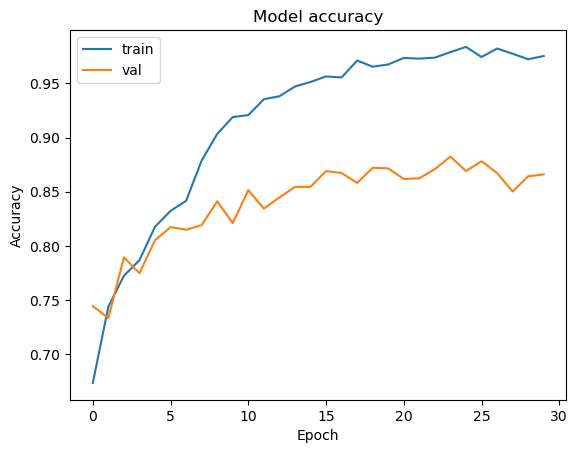

Training accuracy: 0.975397527217865
Validation accuracy: 0.8660170435905457


In [18]:
dropout_model = fit_model(dropout_model, epochs=30)

Our model with dropout will achieve a similar accuracy as our vanilla model. Let’s now run inference with dropout and plot the mean confidence score of MC dropout:

In [19]:
def predictions_dropout(imgs):
    predictions = np.array(  
        [  
            tf.nn.softmax(dropout_model(np.expand_dims(imgs, -1), training=True), axis=1)  
            for _ in range(100)  
        ]  
    )  
    predictions_mean = np.mean(predictions, axis=0)
    return predictions_mean

# GRAD-CAM heatmap

In [20]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def get_resized_heatmap(heatmap, shape):
    """Resize heatmap to shape"""
    # Rescale heatmap to a range 0-255
    upscaled_heatmap = np.uint8(255 * heatmap)

    upscaled_heatmap = zoom(
        upscaled_heatmap,
        (
            shape[0] / upscaled_heatmap.shape[0],
            shape[1] / upscaled_heatmap.shape[1],
            shape[2] / upscaled_heatmap.shape[2],
        ),
    )

    return upscaled_heatmap

def display_gradcam(img, heatmap, alpha=0.4):
    fig, ax = plt.subplots(1, 2, figsize=(10, 20))

    ax[0].imshow(np.squeeze(img), cmap='gray')
    img0 = ax[1].imshow(np.squeeze(img), cmap='gray')
    img1 = ax[1].imshow(np.squeeze(heatmap), cmap='jet', alpha=alpha, extent=img0.get_extent())
    plt.show()

#### Display gradcam for the traditional CNN

In [21]:
def compute_gradcam(img, label, display=True, alpha=0.4):
    # Prepare image
    img_array = img
    #print(f'Original image shape: {img_array.shape}')
    img_array = np.expand_dims(img_array, -1)
    img_array = np.expand_dims(img_array, 0)
    #print(f'Reshaped image shape: {img_array.shape}')

    # Remove last layer's softmax
    model.layers[-1].activation = None

    if display:
        # Print what the top predicted class is
        softmax_predictions = tf.nn.softmax(model(np.expand_dims([img], -1)), axis=1)
        pred_conf = softmax_predictions[0].numpy().max()  
        pred_label = np.argmax(softmax_predictions[0])
        print(f'Prediction: {pred_label} - {round(pred_conf*100, 2)}%')
        print(f'Ground truth: {label}')

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name='conv3d_1')

    # Resize headmap from convolution layer shape to original image shape
    heatmap_upscaled = get_resized_heatmap(heatmap, shape=test_images[10].shape)

    # Superpose heatmap to middle image
    img_plot = np.expand_dims(img, -1)
    if display:
        #print(f'Image to plot shape: {img_plot.shape}')
        display_gradcam(img_plot[2, :, :], heatmap_upscaled[2, :, :], alpha=alpha)
    return heatmap_upscaled, img_plot

#### Display gradcam for the Dropout CNN

In [22]:
def compute_gradcam_dropout(img, label, display=True, alpha=0.4):
    # Prepare image
    img_array = img
    #print(f'Original image shape: {img_array.shape}')
    img_array = np.expand_dims(img_array, -1)
    img_array = np.expand_dims(img_array, 0)
    #print(f'Reshaped image shape: {img_array.shape}')

    # Remove last layer's softmax
    dropout_model.layers[-1].activation = None

    if display:
        # Print what the top predicted class is
        softmax_predictions_drop_out = predictions_dropout([img])
        #softmax_predictions = tf.nn.softmax(model(np.expand_dims([test_images[10]], -1)), axis=1)
        pred_conf = softmax_predictions_drop_out[0].max()  
        pred_label = np.argmax(softmax_predictions_drop_out[0])
        print(f'Prediction: {pred_label} - {round(pred_conf*100, 2)}%')
        print(f'Ground truth: {label}')

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, dropout_model, last_conv_layer_name='conv3d_3')

    # Resize headmap from convolution layer shape to original image shape
    heatmap_upscaled = get_resized_heatmap(heatmap, shape=img.shape)

    # Superpose heatmap to middle image
    img_plot = np.expand_dims(img, -1)
    if display:
        #print(f'Image to plot shape: {img_plot.shape}')
        display_gradcam(img_plot[2, :, :], heatmap_upscaled[2, :, :], alpha=alpha)
    
    return heatmap_upscaled, img_plot

#### Visualize predictions with GRAD-CAM

################## Traditional CNN ##################
Prediction: 0 - 95.73%
Ground truth: 1


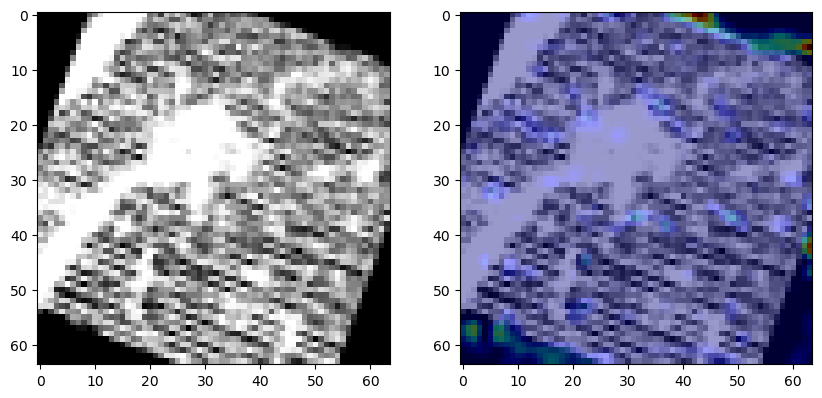

################## Dropout CNN ##################
Prediction: 1 - 89.96%
Ground truth: 1


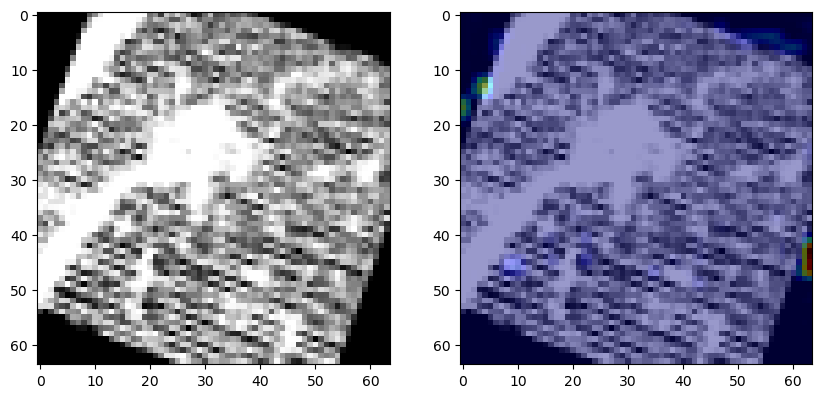

(array([[[ 0,  3,  7, ...,  1,  0,  0],
         [ 0,  3,  7, ...,  8,  5,  3],
         [ 0,  3,  7, ..., 15, 12,  9],
         ...,
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0]],
 
        [[ 0,  3,  6, ...,  0,  0,  0],
         [ 0,  3,  6, ...,  5,  5,  4],
         [ 0,  2,  5, ..., 10, 11, 10],
         ...,
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0]],
 
        [[ 0,  1,  3, ...,  0,  0,  0],
         [ 0,  1,  3, ...,  2,  4,  6],
         [ 0,  1,  1, ...,  3,  9, 12],
         ...,
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0]],
 
        [[ 0,  1,  1, ...,  1,  0,  0],
         [ 0,  0,  0, ...,  2,  5,  7],
         [ 0,  0,  0, ...,  0, 10, 16],
         ...,
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  

In [23]:
img_num = 3
print('################## Traditional CNN ##################')
compute_gradcam(img=test_images[img_num], label=test_labels[img_num], alpha=0.4)
print('################## Dropout CNN ##################')
compute_gradcam_dropout(img=test_images[img_num], label=test_labels[img_num], alpha=0.4)

################## Traditional CNN ##################
Prediction: 0 - 100.0%
Ground truth: 0


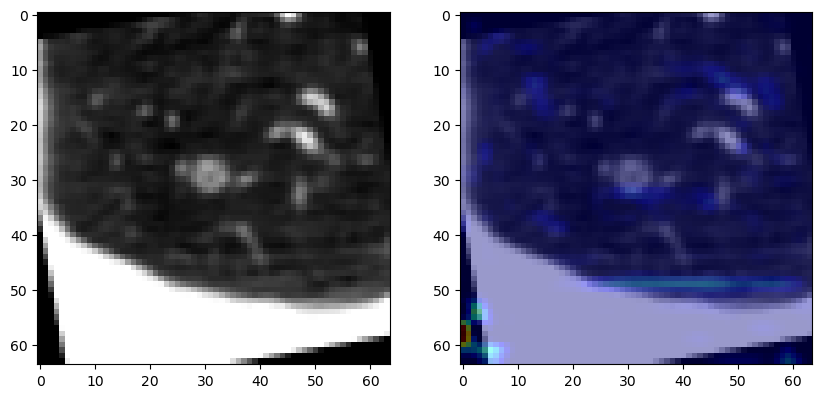

################## Dropout CNN ##################
Prediction: 0 - 99.98%
Ground truth: 0


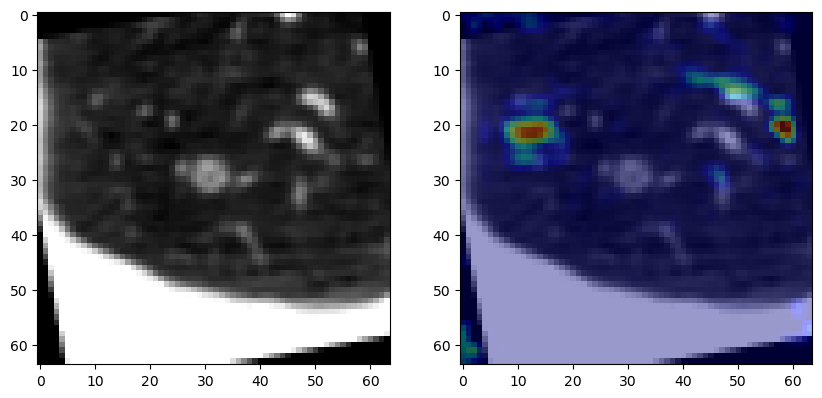

(array([[[  5,   2,   0, ...,   5,   4,   4],
         [ 11,   9,   6, ...,   3,   3,   4],
         [ 18,  16,  12, ...,   0,   1,   4],
         ...,
         [ 72,  92, 105, ...,   0,   0,   0],
         [ 61,  70,  72, ...,   0,   0,   0],
         [ 54,  50,  39, ...,   0,   0,   0]],
 
        [[  9,   7,   6, ...,   5,   3,   3],
         [ 11,  11,  12, ...,   3,   2,   3],
         [ 11,  15,  19, ...,   1,   1,   3],
         ...,
         [ 62,  79,  89, ...,   0,   0,   0],
         [ 53,  60,  60, ...,   0,   0,   0],
         [ 48,  43,  32, ...,   0,   0,   0]],
 
        [[ 19,  18,  19, ...,   4,   2,   0],
         [ 12,  19,  29, ...,   4,   2,   1],
         [  1,  18,  37, ...,   4,   1,   2],
         ...,
         [ 58,  72,  78, ...,   0,   0,   0],
         [ 51,  55,  53, ...,   0,   0,   0],
         [ 47,  41,  29, ...,   0,   0,   0]],
 
        [[ 31,  32,  33, ...,   4,   1,   0],
         [ 21,  34,  50, ...,   5,   2,   1],
         [  5,  32,  65, ...,

In [24]:
img_num = 4
print('################## Traditional CNN ##################')
compute_gradcam(img=test_images[img_num], label=test_labels[img_num], alpha=0.4)
print('################## Dropout CNN ##################')
compute_gradcam_dropout(img=test_images[img_num], label=test_labels[img_num], alpha=0.4)

# Eliminate info from image and see model behaviour change

Now, let’s see how this model handles out-of-distribution data. Imagine we deploy this model to recognize digits, but users sometimes fail to write down the entire digit. What happens when users do not write down the entire digit? We can get an answer to this question by gradually removing more and more information from a digit, and seeing how our model handles the perturbed inputs. We can define our function to remove signal as follows:

In [25]:
def remove_row(img: np.ndarray, row_index: int) -> np.ndarray:  
    img = img.copy()  
    img[:, :row_index, :] = 0  # Set the specified slice to black
    return img

def remove_column(img: np.ndarray, row_column: int) -> np.ndarray:  
    img = img.copy()  
    img[:, :, :row_column] = 0  # Set the specified slice to black
    return img

And then we perturb our images:

In [26]:
def get_imgs_prgs_rem(img, column=False, row=True):
    imgs = []
    img_perturbed = img
    for i in range(0, 64, 4): 
        if row:
            # Set to black until row i
            img_perturbed = remove_row(img_perturbed, i)
        if column:
            # Set to black until column i
            img_perturbed = remove_column(img_perturbed, i)
        if np.array_equal(img, img_perturbed):  
            continue  
        imgs.append(img_perturbed)  
        if img_perturbed.sum() == 0:  
            break
    return imgs

In [27]:
def plot_predictions_traditional(softmax_predictions, imgs, alpha=0.4):
    plt.figure(figsize=(10, 10))  
    bbox_dict = dict(fill=True, facecolor="white", alpha=0.5, edgecolor="white", linewidth=0)
    middle_slice = int(len(imgs[0])/2)
    for i in range(len(imgs)):  
        # Initialize subplot for this image
        ax = plt.subplot(5, 5, i + 1)  
        plt.xticks([])  
        plt.yticks([])  
        plt.grid(False)
        
        # Compute heatmap
        heatmap_upscaled, img_plot = compute_gradcam(img=imgs[i], label=0, display=False)
        # Create ploat of image with superposed heatmap
        img0 = ax.imshow(np.squeeze(img_plot[middle_slice, :, :]), cmap='gray')
        img1 = ax.imshow(np.squeeze(heatmap_upscaled[middle_slice, :, :]), cmap='jet', alpha=alpha, extent=img0.get_extent())
        
        # Add prediction and confidence
        prediction = softmax_predictions[i].numpy().max()  
        label = np.argmax(softmax_predictions[i]) 
        plt.xlabel(f"{label} - {prediction:.2%}")  
        plt.text(0, 3, f" {i+1}", bbox=bbox_dict)
    plt.show()

In [28]:
def plot_predictions_dropout(predictions, imgs, alpha=0.4):
    plt.figure(figsize=(10, 10))  
    bbox_dict = dict(fill=True, facecolor="white", alpha=0.5, edgecolor="white", linewidth=0)
    middle_slice = int(len(imgs[0])/2)
    for i in range(len(imgs)):  
        ax = plt.subplot(5, 5, i + 1)  
        plt.xticks([])  
        plt.yticks([])  
        plt.grid(False)
        
        #plt.imshow(imgs[i][middle_slice], cmap="gray")
        heatmap_upscaled, img_plot = compute_gradcam_dropout(img=imgs[i], label=0, display=False)
        img0 = ax.imshow(np.squeeze(img_plot[middle_slice, :, :]), cmap='gray')
        img1 = ax.imshow(np.squeeze(heatmap_upscaled[middle_slice, :, :]), cmap='jet', alpha=alpha, extent=img0.get_extent())
        
        prediction = predictions[i].max()  
        label = np.argmax(predictions[i])  
        plt.xlabel(f"{label} - {prediction:.2%}")  
        plt.text(0, 3, f" {i+1}", bbox=bbox_dict)
    plt.show()

In [29]:
def plot_predictions(img_num):
    print(f'Ground truth is: {test_labels[img_num]}')

    print('################## Traditional CNN ##################')
    imgs = get_imgs_prgs_rem(test_images[img_num], column=True, row=True)
    softmax_predictions = tf.nn.softmax(model(np.expand_dims(imgs, -1)), axis=1)
    plot_predictions_traditional(softmax_predictions, imgs)

    print('################## Dropout CNN ##################')
    imgs = get_imgs_prgs_rem(test_images[img_num], column=True, row=True)
    predictions_mean = predictions_dropout(imgs)
    plot_predictions_dropout(predictions_mean, imgs)

Ground truth is: 1
################## Traditional CNN ##################


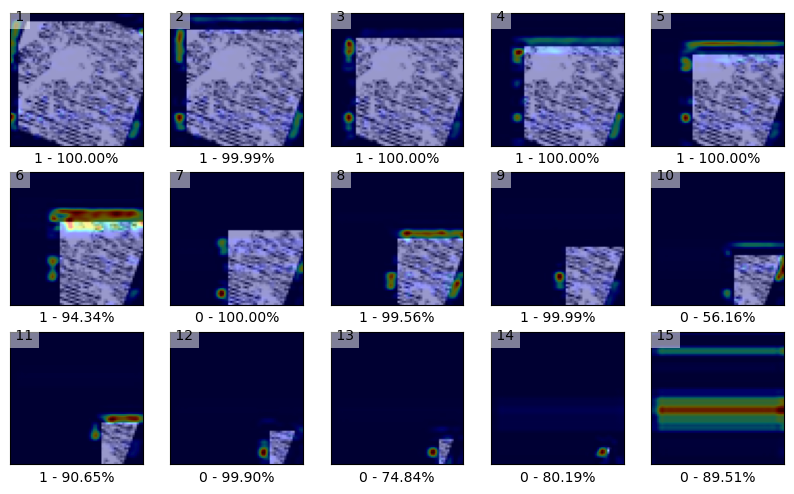

################## Dropout CNN ##################


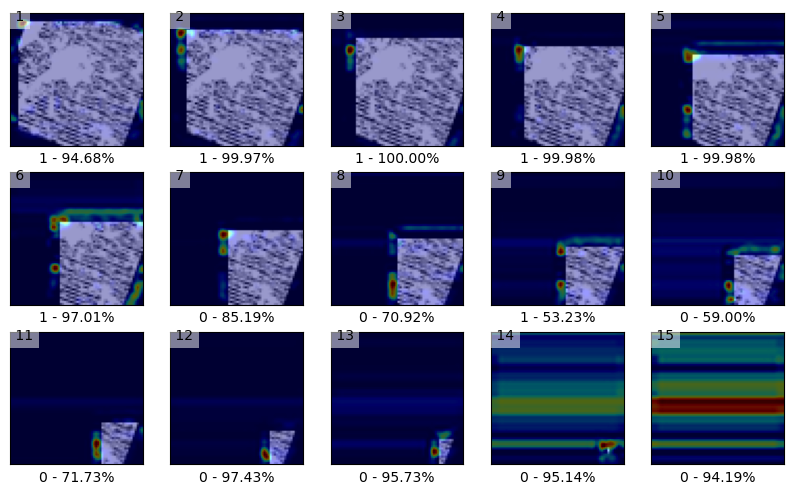

In [30]:
plot_predictions(img_num=3)

Ground truth is: 0
################## Traditional CNN ##################


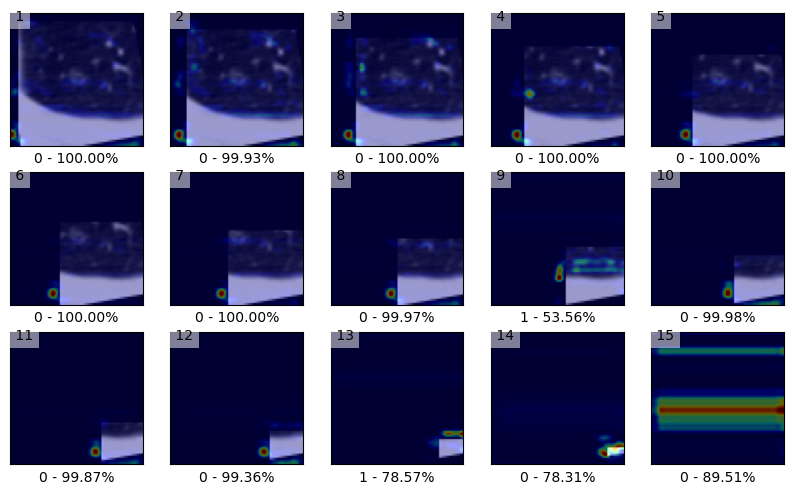

################## Dropout CNN ##################


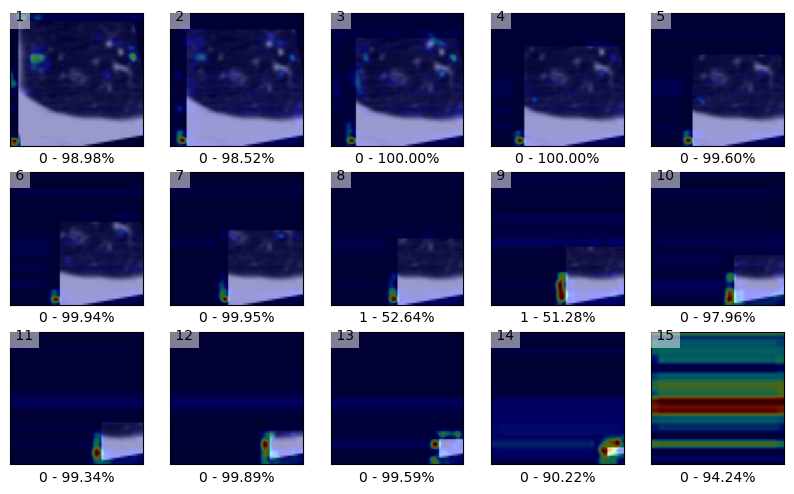

In [31]:
plot_predictions(img_num=4)